In [1]:
from pulp import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import minimize

%matplotlib inline

The following model shows how to calculate two models for scheduling call center agents given some (estimated) demand for customer calls or contacts for a given week. 

We differentiate between permanent employees and temporary call center employees that have different efficiencies, measured in calls per hour, as well cost (per hour).
- We estimate the overall labor requirements by type, and we also
- Estimate the requirements by type by day given a distribution of calls per day

We'll use the [PuLP library](https://github.com/coin-or/pulp) to do the optimization calculation for us using integer programming and discrete optimization.

### Inputs

In [2]:
total_calls = 7000
hours_per_shift = 9

labor_types = ['perm', 'temp']

# Minimum and maximum number of agents per type
min_agents = {'perm': 10, 'temp': 0}
max_agents = {'perm': 50, 'temp': 30}

# Efficiency assumptions
# We assume 5 calls per permanent agent and 3 per temp agent
calls_per_hour_per_agent = {'perm': 5, 'temp': 3}

# The hourly cost in $ per agent per type 
cost_per_agent_hour = {'perm': 20, 'temp': 10}

# We assume agents work 5 day weeks 
days_per_week = 5

# To simplify things, we calculate the number of calls an agent can handle per day 
calls_per_day_per_agent = {'perm': calls_per_hour_per_agent['perm'] * hours_per_shift,
                            'temp': calls_per_hour_per_agent['temp'] * hours_per_shift}

### Total Agent Mix

In [16]:
agents = LpVariable.dicts("Agents",labor_types, 0, None, cat=LpInteger)

# We want to minimize the Labor Cost function
model = LpProblem("Number of Agents", LpMinimize) 

model += lpSum(
    [agents[t] * hours_per_shift * days_per_week * cost_per_agent_hour[t]
               for t in labor_types]
    ), "LaborCost"

# -----------------
# Constraints 
# -----------------

# Must satisfy total demand
model += lpSum([agents[t] * calls_per_day_per_agent[t] * days_per_week
               for t in labor_types]
            ) >= total_calls, 'TotalDemand'

# No more than N agents per type
for t in labor_types:
    model += lpSum([agents[t]]) <= max_agents[t], 'Max_{:}'.format(t)

# Minimum of N agents per type
for t in labor_types:
    model += lpSum([agents[t]]) >= min_agents[t], 'Min_{:}'.format(t)

Let's solve our model:

In [17]:
model.solve(pulp.GLPK())
print (pulp.LpStatus[model.status])

Optimal


We'll turn the model outputs into a dataframe for reporting:

In [21]:
print ('Cost:\t\t ', pulp.value(model.objective) )
# for var in model.variables():
#     print(var, var.varValue)
    
sol_1 = [
    (v.name.split('_')[1], 
       int(v.varValue)
    ) 
       for v in model.variables()
     ]

df_sol_1 = pd.DataFrame(sol_1, columns=['type', 'agents'])

# We'll calculate the total call capacity of our agent pool
for t in labor_types:
    calls_capacity = calls_per_day_per_agent[t] * days_per_week
    agent_call_capacity = df_sol_1.loc[df_sol_1['type'] == t, 'agents'] * calls_capacity
    df_sol_1.loc[df_sol_1['type'] == t, 'call_capacity'] = agent_call_capacity

df_sol_1

Cost:		  25650


,type,agents,call_capacity
0,perm,14,3150.0
1,temp,29,3915.0


So, based on our first model, we'll need 14 permanent and 29 temp employees to satisfy our call demand.

### Agent Mix By Weekday
Our second model breaks out the labor requirements by day, given a set of % of weekly volume for each day

We start the week on Mondays and set the target %s for each weekday

In [22]:
weekdays = {1: 'M', 2: 'T', 3: 'W', 4: 'Th', 5: 'F', 6: 'S', 7: 'Su'}
weekdays

{1: 'M', 2: 'T', 3: 'W', 4: 'Th', 5: 'F', 6: 'S', 7: 'Su'}

In [23]:
wdays = [i for i in range(1, len(weekdays)+1)]
weekday_perc = np.array([.20,.18,.16,.16, .12,.10,.08])
np.sum(weekday_perc)

1.0

In [24]:
weekday_dist = dict(zip(weekdays, weekday_perc))
weekday_dist

{1: 0.20000000000000001,
 2: 0.17999999999999999,
 3: 0.16,
 4: 0.16,
 5: 0.12,
 6: 0.10000000000000001,
 7: 0.080000000000000002}

Let's look at what this distribution looks like:

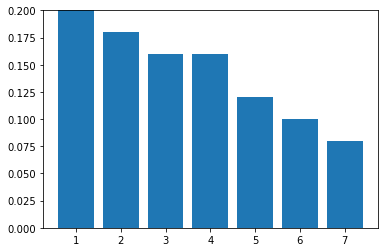

In [25]:
fig, ax = plt.subplots(1, 1)
ax.bar([w for w in range(1, len(weekday_dist.keys())+1)], 
       [v for v in weekday_dist.values()])
ax.set_ylim(0, np.round(np.max([v for v in weekday_dist.values()]), 1));

In [28]:
agents = LpVariable.dicts("Agents",(weekdays, labor_types), 0, None, cat=LpInteger)

# We want to minimize the Labor Cost function
model = LpProblem("Number of Agents by Day", LpMinimize) 

model += lpSum(
    [agents[d][t] * hours_per_shift * cost_per_agent_hour[t]
               for d in weekdays
               for t in labor_types]
    ), "LaborCost"

# -----------------
# Constraints 
# -----------------

# Must satisfy total demand
model += lpSum(
    [agents[d][t] * calls_per_day_per_agent[t]
               for d in weekdays
               for t in labor_types]
) >= total_calls, 'TotalDemand'

# Must satisfy daily demand
for d in weekdays:
    daily_demand = np.ceil(total_calls * weekday_dist[d])
    model += lpSum(
            [agents[d][t] * calls_per_day_per_agent[t] for t in labor_types]
            ) >= daily_demand, 'MinCallsDays_{:}'.format(d)


# No more than N agents per type per weekday
for t in labor_types:
    for d in weekdays:
        max_agnt = 2 if d in (6, 7) and t == 'perm' else max_agents[t] 
        model += lpSum([agents[d][t]]) <= max_agnt, 'Max_{:}_{:}'.format(t, d)

# Minimum of N agents per type per weekday
for t in labor_types:
    for d in weekdays:
        # on the weekends, only 2 minimum perms
        min_agnt = 2 if d in (6, 7) and t == 'perm' else min_agents[t] 
        model += lpSum([agents[d][t]]) >= min_agnt, 'Min_{:}_{:}'.format(t, d)

print(model)

Number of Agents by Day:
MINIMIZE
180*Agents_1_perm + 90*Agents_1_temp + 180*Agents_2_perm + 90*Agents_2_temp + 180*Agents_3_perm + 90*Agents_3_temp + 180*Agents_4_perm + 90*Agents_4_temp + 180*Agents_5_perm + 90*Agents_5_temp + 180*Agents_6_perm + 90*Agents_6_temp + 180*Agents_7_perm + 90*Agents_7_temp + 0
SUBJECT TO
TotalDemand: 45 Agents_1_perm + 27 Agents_1_temp + 45 Agents_2_perm
 + 27 Agents_2_temp + 45 Agents_3_perm + 27 Agents_3_temp + 45 Agents_4_perm
 + 27 Agents_4_temp + 45 Agents_5_perm + 27 Agents_5_temp + 45 Agents_6_perm
 + 27 Agents_6_temp + 45 Agents_7_perm + 27 Agents_7_temp >= 7000

MinCallsDays_1: 45 Agents_1_perm + 27 Agents_1_temp >= 1400

MinCallsDays_2: 45 Agents_2_perm + 27 Agents_2_temp >= 1260

MinCallsDays_3: 45 Agents_3_perm + 27 Agents_3_temp >= 1120

MinCallsDays_4: 45 Agents_4_perm + 27 Agents_4_temp >= 1120

MinCallsDays_5: 45 Agents_5_perm + 27 Agents_5_temp >= 840

MinCallsDays_6: 45 Agents_6_perm + 27 Agents_6_temp >= 700

MinCallsDays_7: 45 Agents_7

In [29]:
model.solve(pulp.GLPK())
print (pulp.LpStatus[model.status])

Optimal


In [31]:
print ('Cost:\t\t ', pulp.value(model.objective) )

# Extract variable values from the solution
sol = [(v.name.split('_')[1], 
        v.name.split('_')[2],
       int(v.varValue)) 
       for v in model.variables()
      ]


Cost:		  25290


We turn the solution's variable values into a dataframe to make reporting easier:

In [32]:
df_sol = pd.DataFrame(sol, columns=['weekday', 'type', 'agents'])

for t in labor_types:
    
    calls_capacity = calls_per_day_per_agent[t] 
    agent_call_capacity = df_sol.loc[df_sol['type'] == t, 'agents'] * calls_capacity
    df_sol.loc[df_sol['type'] == t, 'call_capacity'] = agent_call_capacity

df_sol.pivot_table('agents', 'weekday', 'type', aggfunc='sum')

type,perm,temp
weekday,,
1,14,29
2,10,30
3,10,25
4,10,25
5,11,13
6,2,23
7,2,18


In [33]:
df_sol.pivot_table('call_capacity', 'weekday', 'type', aggfunc='sum')

type,perm,temp
weekday,,
1,630.0,783.0
2,450.0,810.0
3,450.0,675.0
4,450.0,675.0
5,495.0,351.0
6,90.0,621.0
7,90.0,486.0


In [34]:
df_sol.groupby('weekday').sum()

,agents,call_capacity
weekday,,
1,43,1413.0
2,40,1260.0
3,35,1125.0
4,35,1125.0
5,24,846.0
6,25,711.0
7,20,576.0
